In [76]:

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from mlxtend.evaluate import bias_variance_decomp
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os, csv
import sys
sys.path.insert(0, '..')
from text_cluster.data_clean import get_dataframe_from_file

In [77]:
df = get_dataframe_from_file("../cleaned_data_combined.csv", "../text_cluster")
# pd.read_csv("../cleaned_output.csv")
df.dropna(inplace=True)

In [78]:
X = df.drop(columns=['Label']).to_numpy()

y = df['Label'].to_numpy()
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [79]:
# 60% for training and 20% validation, 20% for testing TODO: do we want to adjust this
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=42, stratify=y_train_valid)

In [80]:
# Output data set splits
mapping = {
    'X_train': X_train,
    'y_train': y_train,
    'X_valid': X_valid,
    'y_valid': y_valid,
    'X_test': X_test,
    'y_test': y_test
}
# for name, data in mapping.items():
#     pd.DataFrame(data).to_csv(f'dataset/{name}.csv', index=False)

In [81]:
mlp_param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': loguniform(1e-5, 1e-1), 
    'learning_rate_init': loguniform(1e-4, 1e-2),
    'early_stopping': [True],
    'n_iter_no_change': [10, 25, 50], 
    'max_iter': [500]
}

bagging_param_dist = {
    'estimator__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)], #slightly smaller for speed (may modify if different from mlp_pram_result)
    'estimator__activation': ['relu', 'tanh'],
    'estimator__solver': ['adam'], 
    'estimator__alpha': loguniform(1e-5, 1e-1),
    'estimator__learning_rate_init': loguniform(1e-4, 1e-2),
    'estimator__n_iter_no_change': [10, 25],
    'estimator__max_iter': [300], 

    # Bagging specific parameters
    'n_estimators': randint(10, 51), # Number of base estimators (10 to 50)
    'max_samples': [0.7, 0.8, 0.9, 1.0], # Fraction of samples for each estimator
}


def tune_mlp_classifier(X_train_valid, y_train_valid, n_iter=50, cv=3, random_state=42):
    """
    Tunes MLPClassifier using RandomizedSearchCV.

    Args:
        X_train_valid: Combined training and validation features.
        y_train_valid: Combined training and validation labels.
        n_iter: Number of parameter settings to sample.
        cv: Number of cross-validation folds.
        random_state: Random seed for reproducibility.

    Returns:
        best_estimator: The best MLPClassifier found.
        best_params: The best parameter dictionary found.
    """
    print(f"--- Tuning MLPClassifier (n_iter={n_iter}, cv={cv}) ---")
    # Base MLP model
    base_mlp = MLPClassifier(random_state=random_state, early_stopping=True, validation_fraction=0.1)

    random_search = RandomizedSearchCV(
        estimator=base_mlp,
        param_distributions=mlp_param_dist,
        n_iter=n_iter,
        cv=cv,
        scoring='accuracy', 
        n_jobs=12, # Use all available CPU cores
        random_state=random_state,
        verbose=1,
        refit=True
    )

    random_search.fit(X_train_valid, y_train_valid)

    print(f"Best MLP Score (CV Accuracy): {random_search.best_score_:.4f}")
    print("Best MLP Parameters:")
    print(random_search.best_params_)
    
    return random_search.best_estimator_, random_search.best_params_


def tune_bagging_classifier(X_train_valid, y_train_valid, n_iter=30, cv=3, random_state=42):
    """
    Tunes BaggingClassifier (with MLP base estimator) using RandomizedSearchCV.
    Returs
        best_estimator: The best BaggingClassifier found.
        best_params: The best parameter dictionary found.
    """
    print(f"--- Tuning BaggingClassifier (n_iter={n_iter}, cv={cv}) ---")

    base_mlp_for_bagging = MLPClassifier(random_state=random_state, early_stopping=True, validation_fraction=0.1) 

    # Base Bagging model
    base_bagging = BaggingClassifier(
        estimator=base_mlp_for_bagging,
        random_state=random_state,
        n_jobs=12,

    )

    random_search = RandomizedSearchCV(
        estimator=base_bagging,
        param_distributions=bagging_param_dist,
        n_iter=n_iter,
        cv=cv,
        scoring='accuracy',
        n_jobs=12,
        random_state=random_state,
        verbose=1,
        refit=True
    )

    random_search.fit(X_train_valid, y_train_valid)

    print(f"Best Bagging Score (CV Accuracy): {random_search.best_score_:.4f}")
    print("Best Bagging Parameters:")
    best_params_formatted = {k: v for k, v in random_search.best_params_.items()}
    print(best_params_formatted)

    # Important: The returned best_estimator already has the best base estimator params set
    return random_search.best_estimator_, random_search.best_params_

In [82]:

# Train MLP Classifier
mlp = MLPClassifier(random_state=1, n_iter_no_change=100, early_stopping=True)
mlp.fit(X_train, y_train)


# Train bagged MLP Classifier
bagging = BaggingClassifier(mlp, n_estimators=10, max_samples=0.8, random_state=1, verbose=0)
bagging.fit(X_train, y_train)

C:\Users\rafay\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rafay\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rafay\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rafay\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

BaggingClassifier(estimator=MLPClassifier(early_stopping=True,
                                          n_iter_no_change=100,
                                          random_state=1),
                  max_samples=0.8, random_state=1)

In [83]:
# Normalize the data

scaler = StandardScaler()
normalizer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), [0, 1 ,2])
    ],
    remainder='passthrough'  # Leave other columns unchanged (not sure if this is the issue.. im too lacking )
)

X_train_norm = normalizer.fit_transform(X_train)
X_valid_norm = normalizer.transform(X_valid)
X_test_norm = normalizer.transform(X_test)

# Train MLP Classifier with normalized data
nmlp = MLPClassifier(random_state=1, n_iter_no_change=100, early_stopping=True)
nmlp.fit(X_train_norm, y_train)

# Train bagged MLP Classifier with normalized data
normBagging = BaggingClassifier(nmlp, n_estimators=10, max_samples=0.8, random_state=1)
normBagging.fit(X_train_norm, y_train)



#Training the tuning models
X_train_valid_norm = normalizer.fit_transform(X_train_valid)
X_test_norm = normalizer.transform(X_test)


N_ITER_MLP = 50
N_ITER_BAGGING = 30


best_mlp, best_mlp_params = tune_mlp_classifier(X_train_valid, y_train_valid, n_iter=N_ITER_MLP)
best_bagging, best_bagging_params = tune_bagging_classifier(X_train_valid, y_train_valid, n_iter=N_ITER_BAGGING)

# Normalized
best_nmlp, best_nmlp_params = tune_mlp_classifier(X_train_valid_norm, y_train_valid, n_iter=N_ITER_MLP)
best_normBagging, best_normBagging_params = tune_bagging_classifier(X_train_valid_norm, y_train_valid, n_iter=N_ITER_BAGGING)


C:\Users\rafay\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rafay\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rafay\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rafay\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

--- Tuning MLPClassifier (n_iter=50, cv=3) ---
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best MLP Score (CV Accuracy): 0.8806
Best MLP Parameters:
{'activation': 'relu', 'alpha': np.float64(0.006330402436741773), 'early_stopping': True, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': np.float64(0.005159986718212383), 'max_iter': 500, 'n_iter_no_change': 25, 'solver': 'adam'}
--- Tuning BaggingClassifier (n_iter=30, cv=3) ---
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Bagging Score (CV Accuracy): 0.8852
Best Bagging Parameters:
{'estimator__activation': 'tanh', 'estimator__alpha': np.float64(0.004013783023846251), 'estimator__hidden_layer_sizes': (50,), 'estimator__learning_rate_init': np.float64(0.008706020878304856), 'estimator__max_iter': 300, 'estimator__n_iter_no_change': 25, 'estimator__solver': 'adam', 'max_samples': 0.8, 'n_estimators': 47}
--- Tuning MLPClassifier (n_iter=50, cv=3) ---
Fitting 3 folds for each of 50 candidates, t

In [91]:
def print_bias_variance_decomp(X_train, y_train, X_test, y_test):    
    expected_loss, bias, var = bias_variance_decomp(mlp,
                                                                X_train, y_train, 
                                                                X_test, y_test, 
                                                                num_rounds=20,
                                                                loss='0-1_loss', 
                                                                random_seed=42)
    expected_loss_bagged, bias_bagged, var_bagged = bias_variance_decomp(bagging,
                                                                X_train, y_train, 
                                                                X_test, y_test, 
                                                                num_rounds=20,
                                                                loss='0-1_loss', 
                                                                random_seed=42)
    expected_loss_norm, bias_norm, var_norm = bias_variance_decomp(nmlp,
                                                                X_train_norm, y_train, 
                                                                X_test_norm, y_test, 
                                                                num_rounds=20,
                                                                loss='0-1_loss', 
                                                                random_seed=42)
    expected_loss_bagged_norm, bias_bagged_norm, var_bagged_norm = bias_variance_decomp(normBagging,
                                                                X_train_norm, y_train, 
                                                                X_test_norm, y_test, 
                                                                num_rounds=20,
                                                                loss='0-1_loss', 
                                                                random_seed=42)

    print("Bias-Variance Decomposition Results")
    print("===================================")
    print(f"{'Model':<25} {'Expected Loss':<15} {'Bias':<15} {'Variance':<15}")
    print("-" * 70)
    print(f"{'MLP':<25} {expected_loss:.4f}{' '*10} {bias:.4f}{' '*10} {var:.4f}")
    print(f"{'Bagging MLP':<25} {expected_loss_bagged:.4f}{' '*10} {bias_bagged:.4f}{' '*10} {var_bagged:.4f}")
    print(f"{'Normalized MLP':<25} {expected_loss_norm:.4f}{' '*10} {bias_norm:.4f}{' '*10} {var_norm:.4f}")
    print(f"{'Normalized Bagging MLP':<25} {expected_loss_bagged_norm:.4f}{' '*10} {bias_bagged_norm:.4f}{' '*10} {var_bagged_norm:.4f}")

# print_bias_variance_decomp(X_train, y_train, X_test, y_test)

In [92]:
def export_model(model: MLPClassifier, filename: str, is_bagged: bool = False) -> None:
    """
    Save the bagged model. Note a bagged model is a collection of models, so we need to save each 
    one. This will also result different code for inference
    """
    if is_bagged:
        params = {}
        for i, estimator in enumerate(model.estimators_):
            for j in range(len(estimator.coefs_)):
                params[f'estimator_{i}_weights_{j}'] = estimator.coefs_[j]
                params[f'estimator_{i}_intercepts_{j}'] = estimator.intercepts_[j]
        params['num_estimators'] = len(model.estimators_)
        params['num_layers'] = len(model.estimators_[0].coefs_)
        params['classes'] = model.classes_
        np.savez(filename, **params)
    else:
        params = {f'weights_{i}': coef for i, coef in enumerate(model.coefs_)}
        params.update({f'biases_{i}': intercept for i, intercept in enumerate(model.intercepts_)})
        params['classes'] = model.classes_
        np.savez(filename, **params)

In [93]:
# Export the models
export_model(mlp, 'models/mlp_model.npz')
export_model(bagging, 'models/bagged_model.npz', is_bagged=True)
export_model(nmlp, 'models/normMlp_model.npz')
export_model(normBagging, 'models/normBagged_model.npz', is_bagged=True)
export_model(best_mlp, 'models/best_mlp_model.npz')
export_model(best_bagging, 'models/best_bagged_model.npz', is_bagged=True)
export_model(best_nmlp, 'models/best_normMlp_model.npz')
export_model(best_normBagging, 'models/best_normBagged_model.npz', is_bagged=True)


In [94]:
def score_and_export_results(model: MLPClassifier, X_train: pd.DataFrame, y_train: pd.Series, 
                             X_valid: pd.DataFrame, y_valid: pd.Series,
                             X_test: pd.DataFrame, y_test: pd.Series,
                             model_name: str, 
                             file_name: str) -> None:
    """
    Score the model and save the results of the model to file_name.
    """
    train_score = model.score(X_train, y_train)
    valid_score = model.score(X_valid, y_valid)
    test_score = model.score(X_test, y_test)
    print(f"Model: {model_name}")
    print(f"Training Score: {train_score:.4f}")
    print(f"Validation Score: {valid_score:.4f}")
    print(f"Test Score: {test_score:.4f}\n")
    
    params = {
        "Model": model_name,
        "Training Score": train_score,
        "Validation Score": valid_score,
        "hidden_layer_sizes": "",
        "activation": "",
        "solver": "",
        "alpha": "",
        "learning_rate_init": "",
        "n_iter_no_change": "",
        "n_estimators": "",
        "max_samples": ""
    }
    
                
    base_model = model
    if isinstance(model, BaggingClassifier):
        base_model = model.estimator_ # Access base estimator
        params["n_estimators"] = model.n_estimators
        params["max_samples"] = model.max_samples

    if isinstance(base_model, MLPClassifier):
        params["hidden_layer_sizes"] = str(base_model.hidden_layer_sizes)
        params["activation"] = base_model.activation
        params["solver"] = base_model.solver
        params["alpha"] = base_model.alpha
        params["learning_rate_init"] = base_model.learning_rate_init
        if hasattr(base_model, 'learning_rate'): # Check if attribute exists
             params["learning_rate"] = base_model.learning_rate
        if hasattr(base_model, 'n_iter_no_change'):
             params["n_iter_no_change"] = base_model.n_iter_no_change

    fieldnames = list(params.keys())
    # Write to CSV
    file_exists = os.path.isfile(file_name)
    with open(file_name, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()
        writer.writerows([params])

In [101]:
models = {
    "Base": (mlp, X_valid, y_valid, X_train, y_train, X_test, y_test),
    "Bagging": (bagging, X_valid, y_valid, X_train, y_train, X_test, y_test),
    "Normalized": (nmlp, X_valid_norm, y_valid, X_train_norm, y_train, X_test_norm, y_test),
    "Normalized Bagging": (normBagging, X_valid_norm, y_valid, X_train_norm, y_train, X_test_norm, y_test),
    "Tuned Base": (best_mlp, X_valid, y_valid, X_train, y_train, X_test, y_test),
    "Tuned Bagging": (best_bagging, X_valid, y_valid, X_train, y_train, X_test, y_test),
    "Tuned Normalized": (best_nmlp, X_valid_norm, y_valid, X_train_norm, y_train, X_test_norm, y_test),
    "Tuned Normalized Bagging": (best_normBagging, X_valid_norm, y_valid, X_train_norm, y_train, X_test_norm, y_test),
}

for name, (model, X_valid, y_valid, X_train, y_train, X_test, y_test) in models.items():
    score_and_export_results(model, X_train, y_train, X_valid, y_valid, X_test, y_test, name, "model_results.csv")

Model: Base
Training Score: 0.9040
Validation Score: 0.8859
Test Score: 0.8693

Model: Bagging
Training Score: 0.9249
Validation Score: 0.8973
Test Score: 0.8784

Model: Normalized
Training Score: 0.9363
Validation Score: 0.8935
Test Score: 0.8723

Model: Normalized Bagging
Training Score: 0.9411
Validation Score: 0.8973
Test Score: 0.8663

Model: Tuned Base
Training Score: 0.9249
Validation Score: 0.9582
Test Score: 0.8571

Model: Tuned Bagging
Training Score: 0.9287
Validation Score: 0.9316
Test Score: 0.8754

Model: Tuned Normalized
Training Score: 0.9325
Validation Score: 0.9506
Test Score: 0.8845

Model: Tuned Normalized Bagging
Training Score: 0.9525
Validation Score: 0.9734
Test Score: 0.8784



              precision    recall  f1-score   support

       Pizza       0.89      0.89      0.89        88
    Shawarma       0.86      0.89      0.87        88
       Sushi       0.92      0.89      0.90        87

    accuracy                           0.89       263
   macro avg       0.89      0.89      0.89       263
weighted avg       0.89      0.89      0.89       263

              precision    recall  f1-score   support

       Pizza       0.98      0.94      0.96        88
    Shawarma       0.93      0.98      0.96        88
       Sushi       0.97      0.95      0.96        87

    accuracy                           0.96       263
   macro avg       0.96      0.96      0.96       263
weighted avg       0.96      0.96      0.96       263

              precision    recall  f1-score   support

       Pizza       0.92      0.90      0.91        88
    Shawarma       0.87      0.91      0.89        88
       Sushi       0.91      0.89      0.90        87

    accuracy        

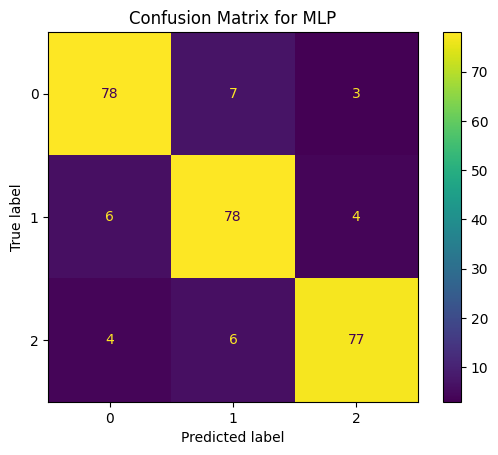

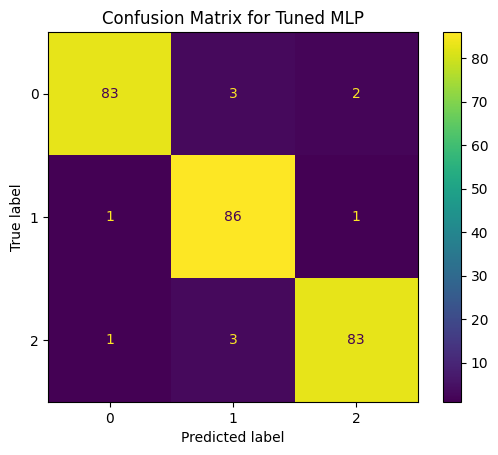

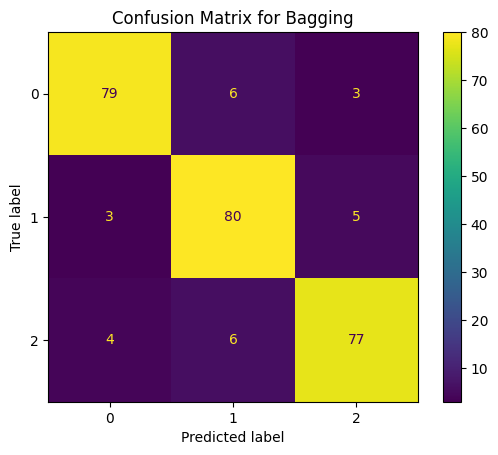

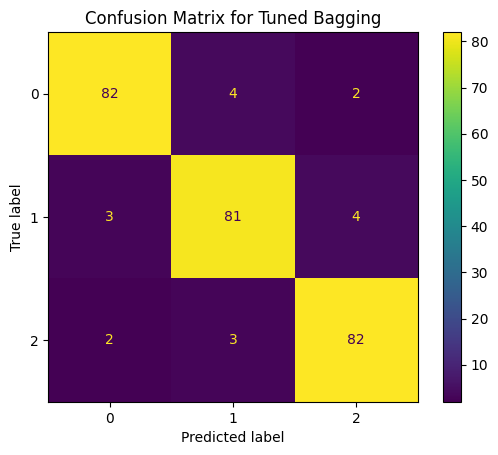

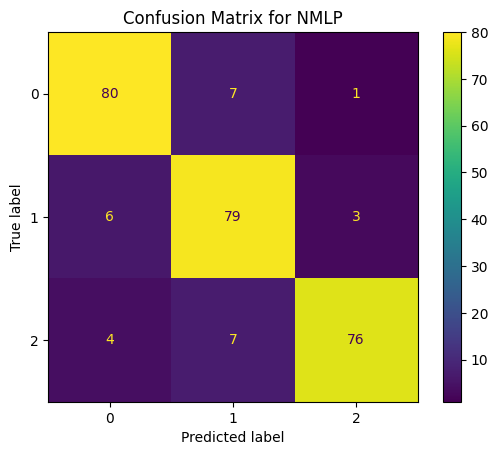

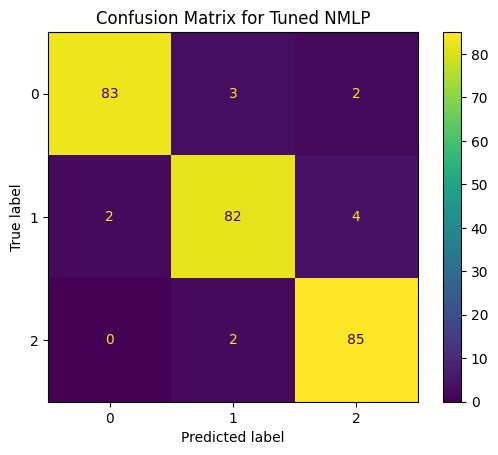

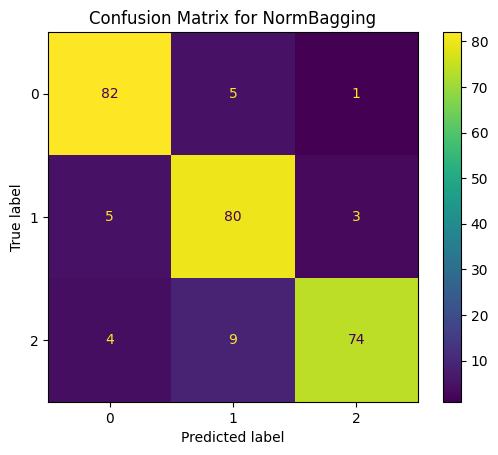

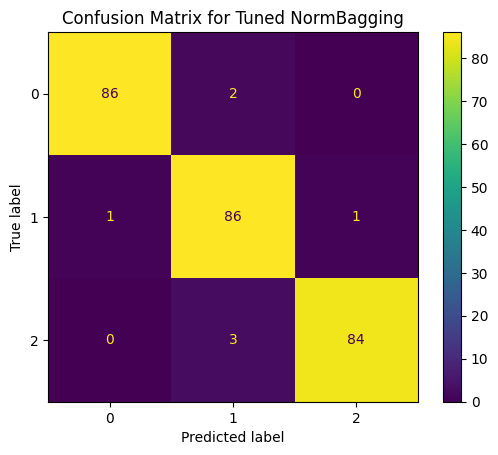

In [100]:
# predictions = bagging.predict(X_valid)

# print(classification_report(y_valid, predictions, target_names=encoder.classes_))


def plot_confusion_matrix(X, t, lr, group = "Everyone"):
    """
    Use the sklearn model "lr" to make predictions for the data "X",
    then compare the prediction with the target "t" to plot the confusion matrix.

    Moreover, this function prints the accuracy, precision and recall
    """
    cm = confusion_matrix(t, lr.predict(X))
    print(classification_report(t, lr.predict(X), target_names=encoder.classes_))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
    
    disp.plot()
    # tn, fp, fn, tp = cm.ravel()
    # print("Confusion Matrix: ", np.array([[tp, fp], [fn, tn]]))
    # print("Accuracy: ", ((tp + tn) / (tp + fp + fn + tn)))
    # print("Precision: ", (tp / (tp + fp)))
    # print("Recall: ", (tp / (tp + fn)))
    plt.title(f"Confusion Matrix for {group}")

    # plt.show()
    

# print(confusion_matrix(y_valid, predictions, labels=encoder.transform(encoder.classes_)))

plot_confusion_matrix(X_valid, y_valid, mlp, group="MLP")
plot_confusion_matrix(X_valid, y_valid, best_mlp, group="Tuned MLP")


plot_confusion_matrix(X_valid, y_valid, bagging, group="Bagging")
plot_confusion_matrix(X_valid, y_valid, best_bagging, group="Tuned Bagging")


plot_confusion_matrix(X_valid, y_valid, nmlp, group="NMLP")
plot_confusion_matrix(X_valid, y_valid, best_nmlp, group="Tuned NMLP")


plot_confusion_matrix(X_valid, y_valid, normBagging, group="NormBagging")
plot_confusion_matrix(X_valid, y_valid, best_normBagging, group="Tuned NormBagging")


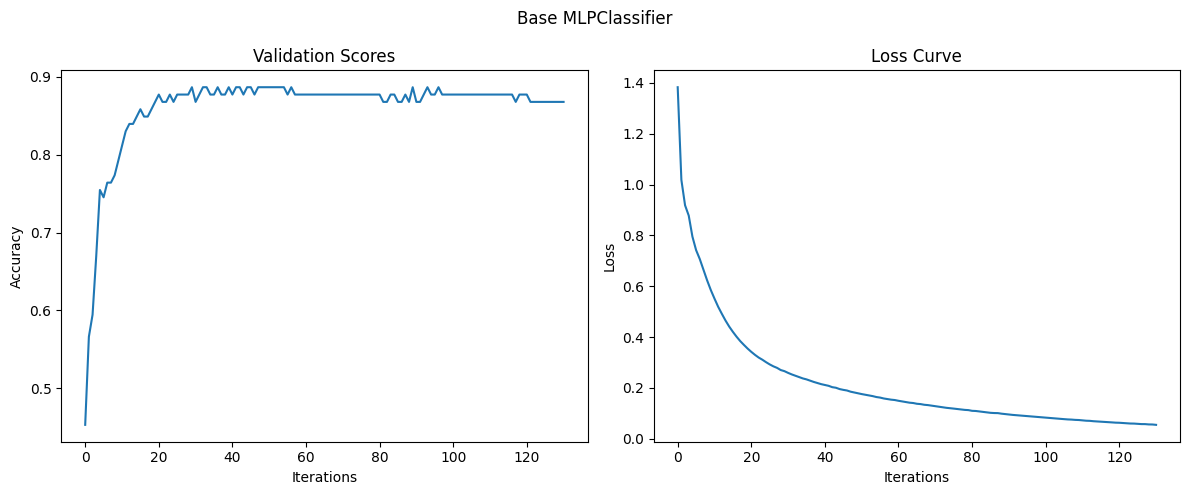

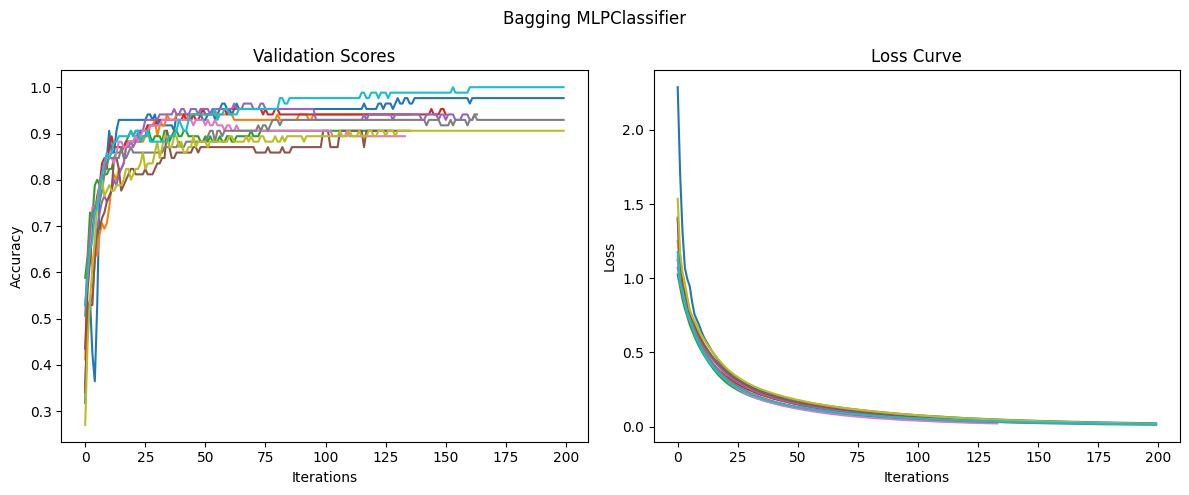

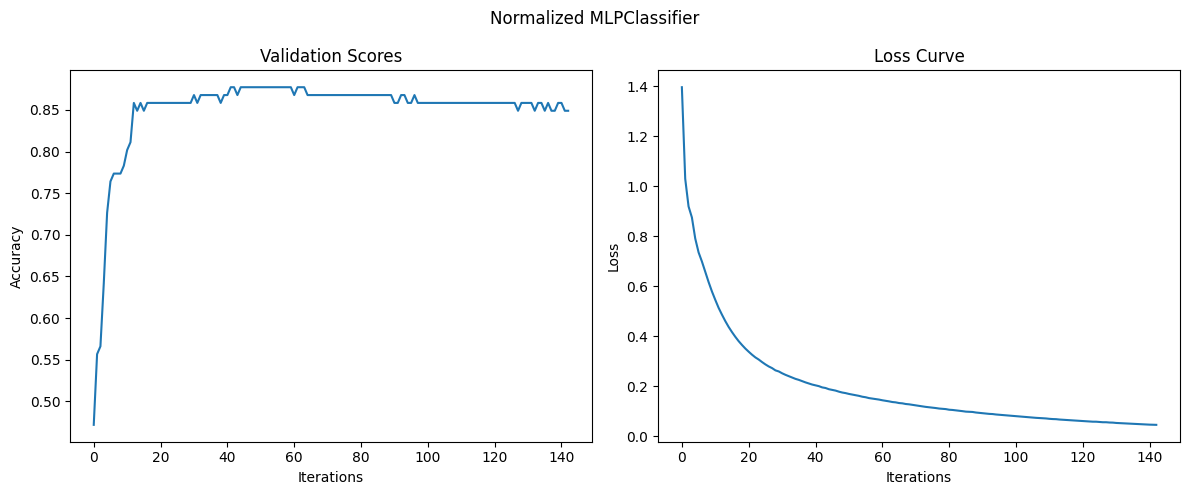

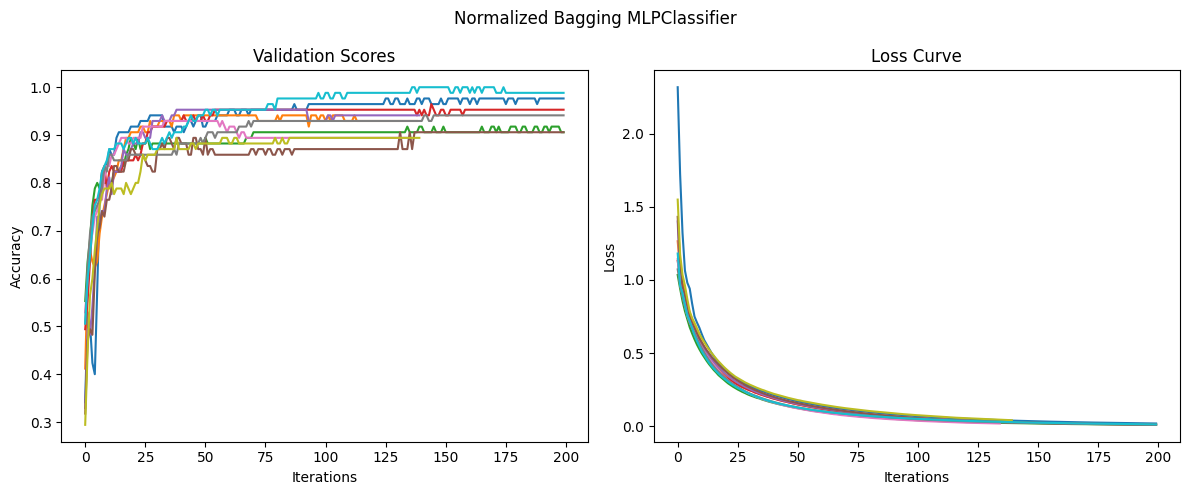

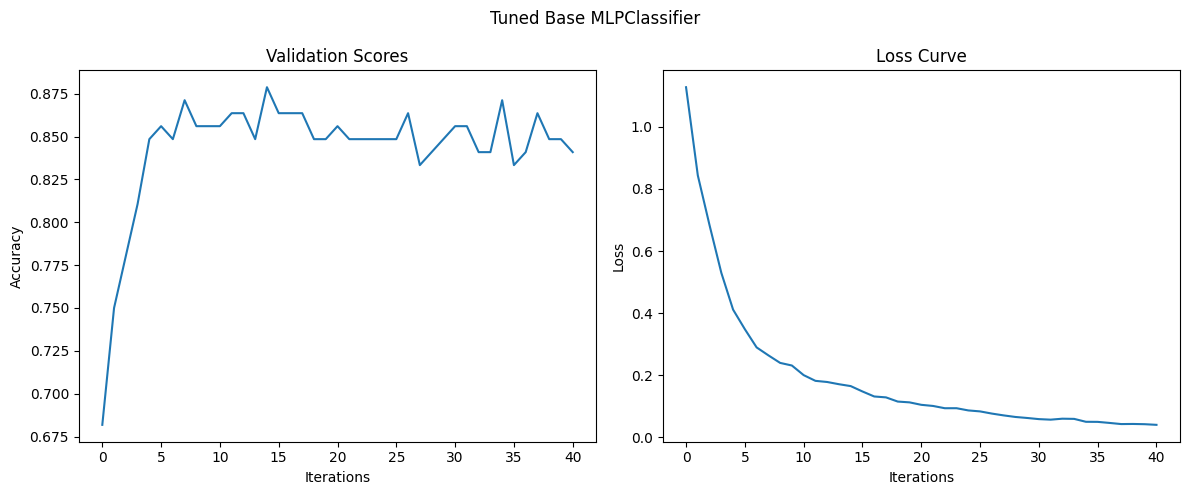

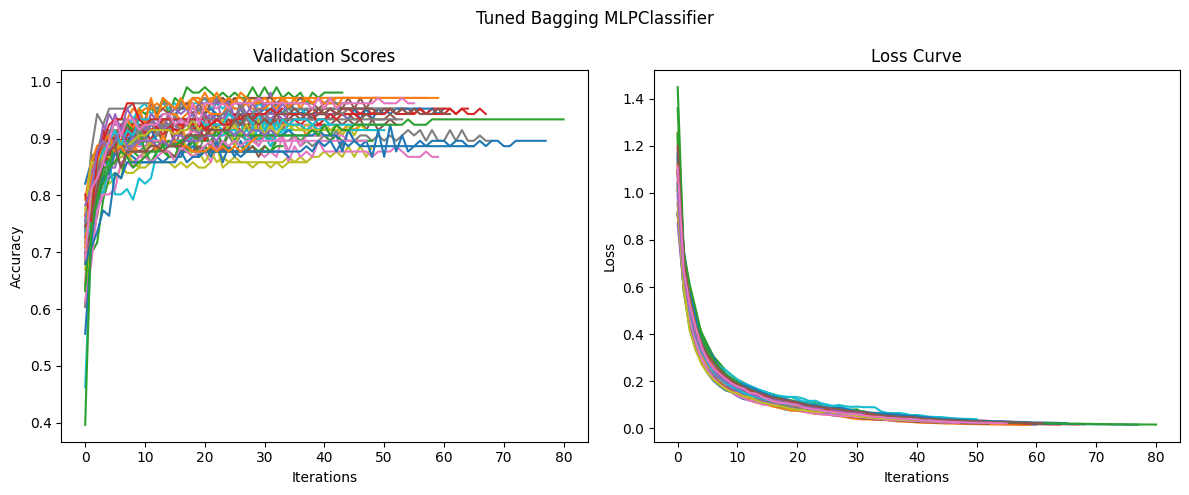

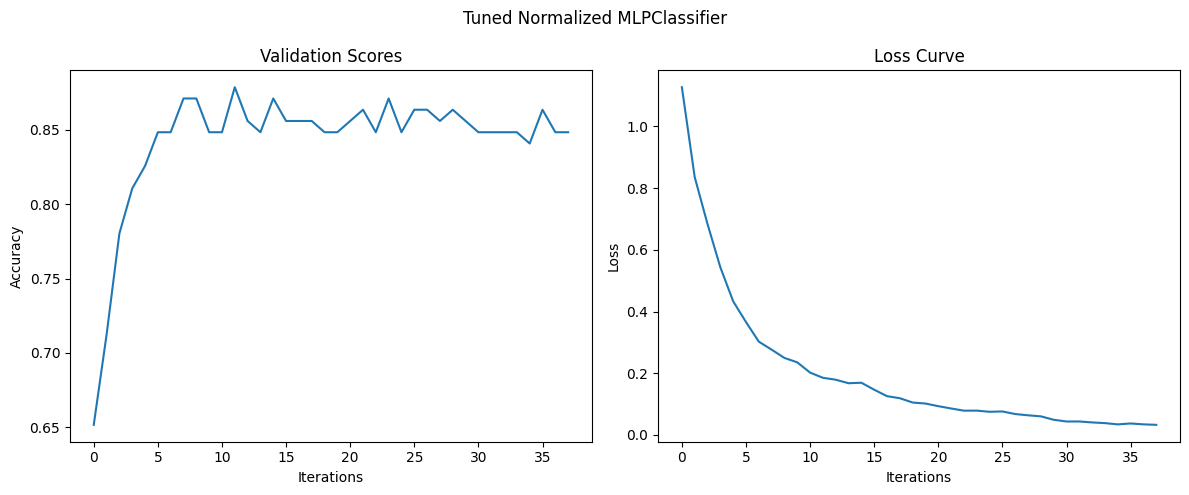

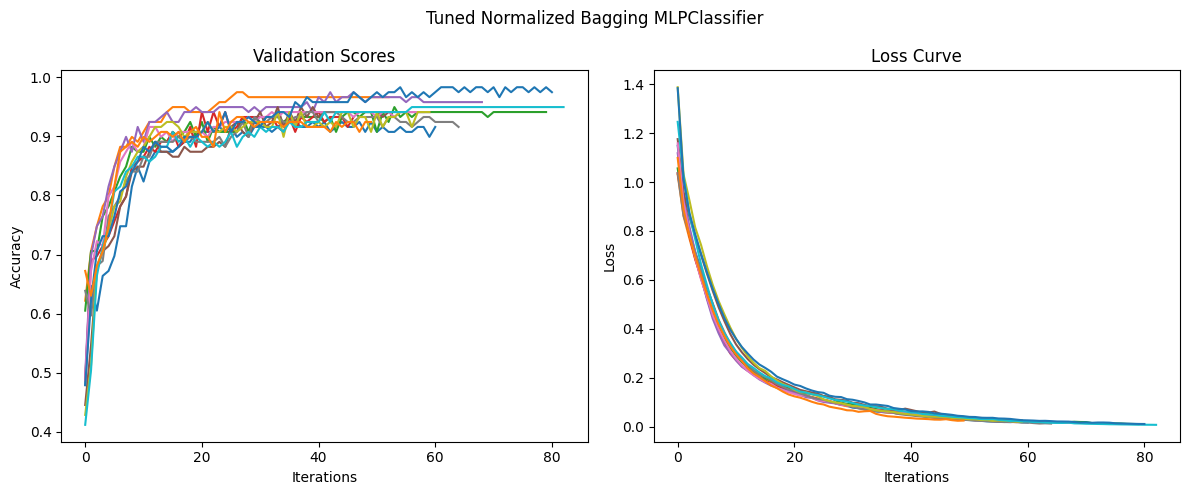

In [90]:
from plot import plot_single_model, plot_bagging_training_progress

plot_single_model(mlp, "Base MLPClassifier")
plot_bagging_training_progress(bagging, "Bagging MLPClassifier")
plot_single_model(nmlp, "Normalized MLPClassifier")
plot_bagging_training_progress(normBagging, "Normalized Bagging MLPClassifier")

plot_single_model(best_mlp, "Tuned Base MLPClassifier")
plot_bagging_training_progress(best_bagging, "Tuned Bagging MLPClassifier")
plot_single_model(best_nmlp, "Tuned Normalized MLPClassifier")
plot_bagging_training_progress(best_normBagging, "Tuned Normalized Bagging MLPClassifier")



